# Data Science Final Project - EE 379k - sp18 - 

# Shahshank Kambhampati - skk834, Shrikara Murthy - svm456, Pranav Harathi - , Neil Charles - 

# Job Satisfaction Prediction

## Imports

### All hail lord and savior XGB

In [12]:
import pandas as pd
import re
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from scipy import stats
from sklearn.linear_model import RidgeCV, LassoCV, LogisticRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomTreesEmbedding, AdaBoostClassifier, AdaBoostRegressor, RandomForestRegressor, RandomForestClassifier, VotingClassifier
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import LeaveOneOut, train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import RFE,RFECV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.feature_selection import SelectKBest,  chi2
from sklearn.svm import SVR

from __future__ import print_function
%config inlinebackend.figure_format = 'retina' 
%matplotlib inline

# Initial Observations about the Data and Pre-Processing

In [2]:
number = re.compile('[\d,]+')
def get_first_number(val):
    matched = number.match(str(val))
    if matched:
        return int(matched.group())
    else:
        return np.nan

satisfaction_strs = {
    'I love my job': 10,
    'I\'m somewhat satisfied with my job': 7.5,
    'I\'m neither satisfied nor dissatisfied with my job': 5,
    'I\'m somewhat dissatisfied with my job': 2.5,
    'I hate my job': 0,
}

binary_labels = [
    'Lang & Tech',
    'Training & Education',
    'How can companies improve interview process',
    'Why try Stack Overflow Careers',
    'Most important aspect of new job opportunity',
    'Most annoying about job search',
    'Appealing message traits',
    'Most urgent info about job opportunity',
    'Who do you want to communicate with about a new job opportunity',
    'Why use Stack Overflow',
    'Why answer',
    'Source control used',
]

numeric_labels = [
    'Age',
    'Years IT / Programming Experience',
    'Compensation: midpoint'
]

yes_no_labels = [
    'Changed Jobs in last 12 Months'
]


In [3]:
# 2015 preproc
data = pd.read_csv('data/2015.csv')
to_drop = [label for label in data if 'write-in' in label.lower()]

data['Job Satisfaction'] = data['Job Satisfaction']\
                                    .map(satisfaction_strs).astype('float')
data = data[data['Job Satisfaction'].notnull()]
to_drop.append('Country')
to_drop.append('Compensation')

data['Age'] = data['Age'].map(get_first_number).astype('float')
data['gender_M'] = (data['Gender'] == 'Male').astype('int8')
data['gender_F'] = (data['Gender'] == 'Female').astype('int8')
to_drop.append('Gender')
to_drop.append('Prefered Source Control')

bin_labels = [key for key in data if any(label in key for label in binary_labels)]
data[bin_labels] = data[bin_labels].apply(lambda col: col.notnull().astype('int8'))

data[numeric_labels] = data[numeric_labels].applymap(get_first_number)
data[yes_no_labels] = data[yes_no_labels]\
                                .apply(lambda col: col.map({'Yes': 1, 'No': 0}))\
                                .fillna(0)

data.drop(to_drop, axis=1, inplace=True)
data = pd.get_dummies(data)

print("Columns with NaNs:")

for key in data:
    if data[key].isnull().any():
        print (key)
data.fillna(data.mean(), inplace=True)
print ('Filling with mean of column')

/home/shrikar/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,108,121,196,197,198) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Columns with NaNs:
Age
Years IT / Programming Experience
Compensation: midpoint
Filling with mean of column


In [4]:
# data contains a DataFrame with no NaNs, all numbers.
# We're trying to predict the "Job Satisfaction" column.

In [4]:
#X = data[['Compensation: midpoint','Purchasing Power_I have no say in purchasing what I need or want at work','Remote Status_Never','Changed Jobs in last 12 Months']]
X = data.drop('Job Satisfaction',axis=1)
y = data['Job Satisfaction']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,stratify=y)#stratify=y
scoring = {'mean': make_scorer(mean_squared_error)}

In [5]:
print (data.head())

    Age  Years IT / Programming Experience  Current Lang & Tech: Android  \
0  25.0                                2.0                             0   
1  20.0                                1.0                             0   
2  20.0                                1.0                             0   
3  25.0                                6.0                             0   
4  30.0                                2.0                             0   

   Current Lang & Tech: Arduino  Current Lang & Tech: AngularJS  \
0                             0                               0   
1                             0                               0   
2                             0                               0   
3                             0                               0   
4                             0                               0   

   Current Lang & Tech: C  Current Lang & Tech: C++  \
0                       0                         0   
1                       0     

In [7]:
print (data.describe())

                Age  Years IT / Programming Experience  \
count  16004.000000                       16004.000000   
mean      28.478348                           5.839325   
std        6.955481                           3.850501   
min       20.000000                           1.000000   
25%       25.000000                           2.000000   
50%       25.000000                           6.000000   
75%       30.000000                          11.000000   
max       51.000000                          11.000000   

       Current Lang & Tech: Android  Current Lang & Tech: Arduino  \
count                  16004.000000                  16004.000000   
mean                       0.173269                      0.061110   
std                        0.378492                      0.239539   
min                        0.000000                      0.000000   
25%                        0.000000                      0.000000   
50%                        0.000000                      0.0000

In [8]:
for i in data.corr():
    print (i)

KeyboardInterrupt: 

In [ ]:
model = xgb.XGBRegressor()
rfe = RFE(model, 50,2)
rfe = rfe.fit(X_train,y_train)
X_train = rfe.transform(X_train)
X_test = rfe.transform(X_test)
#rfe_preds = rfe.predict(X_test)
#print mean_squared_error(y_test,rfe_preds)


In [ ]:
parameters = {
    'n_estimators':[160]
}
modelETC = ExtraTreesRegressor()
gridETC = GridSearchCV(modelETC, param_grid=parameters,scoring = scoring, cv=5, refit = 'mean',verbose=1)
gridETC.fit(X_train,y_train)
print(gridETC.best_params_)
#print(modelETC.feature_importances_)
etc_preds = gridETC.predict(X_test)
print (mean_squared_error(y_test,etc_preds))

In [ ]:
print mean_squared_error(y_test,etc_preds)

2.471834236419676


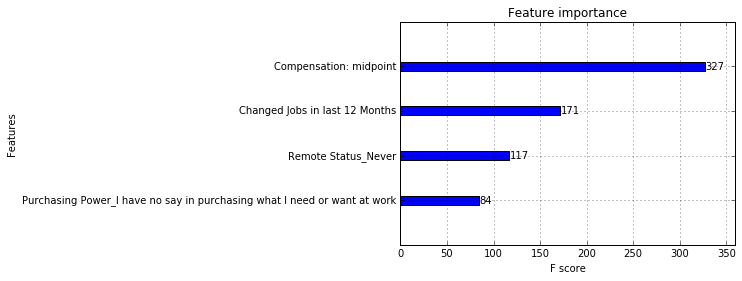

In [6]:
xgb_model = xgb.XGBRegressor()
#gridXGB = GridSearchCV(xgb_model, param_grid=parameters,scoring = scoring, cv=3, verbose=2, refit = 'mean')
#gridXGB.fit(X_train, y_train,eval_metric='rmse')
#print(gridXGB.best_params_)
#xgb_preds = gridXGB.predict(X_test)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
print (mean_squared_error(y_test,xgb_preds)**.5)
#xgb_copy = list(xgb_preds)
xgb_model.fit(X, y)
xgb_model._Booster.save_model('output2015.model')
xgb.plot_importance(xgb_model,max_num_features = 10)


In [13]:
xgb_model._Booster.predict(xgb.DMatrix([0.0,0.0,0.0,0.0], feature_names=[u'Compensation: midpoint', u'Purchasing Power_I have no say in purchasing what I need or want at work', u'Remote Status_Never', u'Changed Jobs in last 12 Months']))

array([7.33352], dtype=float32)

In [19]:
parameters = { #when use hyperthread, xgboost may become slower
              'booster':['gbtree'],# dart is nice but far too slow
              'learning_rate': [.01], #
              'max_depth': [7],#1,3,5,6,7,8,10
              'min_child_weight': [8],#1,3,5,7,8,9,10
              'reg_alpha':[.01],#.0001,.001,.01,.1,1,10
              'silent': [0],
              'subsample': [.6],#.6,.7,.8,.9
              'gamma':[.001],#.1,.01,.001.,.005,0
              'colsample_bytree': [.8],#.6,.7,.8,.9
              'n_estimators': [10000], 
              'seed': [1337]
}

In [20]:
xgb_model = xgb.XGBRegressor()
gridXGB = GridSearchCV(xgb_model, param_grid=parameters,scoring = scoring, cv=3, verbose=2, refit = 'mean')
gridXGB.fit(X_train, y_train,eval_metric='rmse')
#print(gridXGB.best_params_)
xgb_preds = gridXGB.predict(X_test)
#xgb_model.fit(X_train, y_train)
#xgb_preds = xgb_model.predict(X_test)
print (mean_squared_error(y_test,xgb_preds)**.5)
#xgb_copy = list(xgb_preds)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] reg_alpha=0.01, colsample_bytree=0.8, silent=0, learning_rate=0.01, min_child_weight=8, n_estimators=10000, subsample=0.6, seed=1337, max_depth=7, gamma=0.001, booster=gbtree 
[CV]  reg_alpha=0.01, colsample_bytree=0.8, silent=0, learning_rate=0.01, min_child_weight=8, n_estimators=10000, subsample=0.6, seed=1337, max_depth=7, gamma=0.001, booster=gbtree, total=21.1min
[CV] reg_alpha=0.01, colsample_bytree=0.8, silent=0, learning_rate=0.01, min_child_weight=8, n_estimators=10000, subsample=0.6, seed=1337, max_depth=7, gamma=0.001, booster=gbtree 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 21.4min remaining:    0.0s


[CV]  reg_alpha=0.01, colsample_bytree=0.8, silent=0, learning_rate=0.01, min_child_weight=8, n_estimators=10000, subsample=0.6, seed=1337, max_depth=7, gamma=0.001, booster=gbtree, total=25.0min
[CV] reg_alpha=0.01, colsample_bytree=0.8, silent=0, learning_rate=0.01, min_child_weight=8, n_estimators=10000, subsample=0.6, seed=1337, max_depth=7, gamma=0.001, booster=gbtree 
[CV]  reg_alpha=0.01, colsample_bytree=0.8, silent=0, learning_rate=0.01, min_child_weight=8, n_estimators=10000, subsample=0.6, seed=1337, max_depth=7, gamma=0.001, booster=gbtree, total=21.7min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 68.6min finished


2.2666836788652214


In [9]:
print(gridXGB.best_params_)

NameError: name 'gridXGB' is not defined

In [17]:
print (mean_squared_error(y_test,xgb_preds)**.5)


2.322300794571225


In [47]:
print (sum(y_test)/len(y_test))
print (sum(xgb_preds)/len(xgb_preds))

7.5
7.492633136249195


In [6]:
parameters = {
    'n_estimators':[1],
    'learning_rate':[.1]
   # 'base_estimator':[ExtraTreesClassifier(160,class_weight='balanced')]
   # 'base_estimator':[grid]
}
modelABC = AdaBoostRegressor(base_estimator=xgb.XGBRegressor(reg_alpha=.01, colsample_bytree=.8, 
                                silent=0, learning_rate=.01, min_child_weight=8, n_estimators=10000, 
                                            subsample=.6, max_depth=7,gamma=.001,booster='gbtree'),n_estimators = 20)
#gridABC = GridSearchCV(modelABC, param_grid=parameters,scoring = scoring, cv=2, refit = 'mean',verbose=2)
modelABC.fit(X_train,y_train)
abc_preds = modelABC.predict(X_test)
print (mean_squared_error(y_test,abc_preds)**.5)
#print(gridABC.best_params_)
#print(model.feature_importances_)

2.2432018773173352


In [48]:
def clipS(preds):
    for pred, element in enumerate(preds):
        if preds[pred] < 1.25:
            preds[pred] = 0
        elif preds[pred] < 3.75:
            preds[pred] = 2.5
        elif  preds[pred] < 6.25:
            preds[pred] = 5
        elif  preds[pred] < 8.75:
            preds[pred] = 7.5
        else: 
            preds[pred] = 10
    return preds

In [49]:
for pred, clipped, actual in zip(xgb_preds, clipS(xgb_copy), y_test ):
    print (pred, clipped, actual)

8.286079 7.5 10.0
7.927208 7.5 7.5
6.8665676 7.5 7.5
7.365894 7.5 7.5
8.49939 7.5 5.0
7.1254463 7.5 5.0
6.702565 7.5 7.5
5.842753 5 7.5
8.738859 7.5 10.0
7.841649 7.5 10.0
6.74351 7.5 7.5
7.807215 7.5 7.5
9.261417 10 7.5
7.109841 7.5 5.0
6.8010564 7.5 7.5
7.597346 7.5 10.0
6.9410725 7.5 2.5
6.5449824 7.5 0.0
7.402582 7.5 5.0
6.431654 7.5 0.0
7.1956844 7.5 7.5
7.6999984 7.5 10.0
6.1977854 5 2.5
7.982983 7.5 10.0
7.190724 7.5 7.5
6.7932687 7.5 10.0
8.369915 7.5 7.5
8.421787 7.5 7.5
7.026611 7.5 7.5
6.857605 7.5 7.5
8.973689 10 10.0
6.7475266 7.5 2.5
8.897934 10 7.5
7.8295035 7.5 10.0
9.146121 10 10.0
8.495934 7.5 7.5
6.728901 7.5 7.5
7.36117 7.5 10.0
8.701159 7.5 10.0
7.6483 7.5 10.0
7.262645 7.5 7.5
7.3512554 7.5 7.5
7.0285273 7.5 10.0
8.729461 7.5 7.5
7.8325706 7.5 7.5
8.742565 7.5 10.0
6.331672 7.5 0.0
8.884819 10 7.5
7.004472 7.5 7.5
7.0543513 7.5 5.0
7.403653 7.5 10.0
7.0553303 7.5 7.5
7.1007104 7.5 7.5
4.405138 5 5.0
6.3311124 7.5 5.0
7.363051 7.5 5.0
6.0551515 5 2.5
9.117585 10 10

7.2498374 7.5 10.0
7.0629873 7.5 10.0
6.8996253 7.5 7.5
6.8121514 7.5 10.0
7.2658896 7.5 2.5
8.852533 10 10.0
7.584811 7.5 5.0
8.762749 10 10.0
6.7032113 7.5 7.5
7.040448 7.5 7.5
8.731287 7.5 10.0
8.339863 7.5 10.0
9.299665 10 10.0
7.84971 7.5 7.5
5.7796865 5 7.5
5.215879 5 2.5
6.0454664 5 5.0
7.069505 7.5 7.5
7.026026 7.5 10.0
8.7816305 10 7.5
7.6395483 7.5 10.0
8.811912 10 7.5
7.073048 7.5 7.5
6.7585797 7.5 7.5
5.5238676 5 7.5
7.074044 7.5 7.5
8.605527 7.5 10.0
4.81072 5 2.5
6.474626 7.5 10.0
7.489467 7.5 10.0
6.297437 7.5 7.5
9.015276 10 10.0
7.1141887 7.5 2.5
8.855669 10 7.5
7.5748086 7.5 7.5
7.4217353 7.5 10.0
7.6471562 7.5 7.5
6.816087 7.5 5.0
8.472724 7.5 10.0
6.552516 7.5 7.5
7.1472735 7.5 2.5
5.7331457 5 7.5
6.8766747 7.5 2.5
5.6829224 5 2.5
9.096558 10 10.0
7.444388 7.5 7.5
8.846415 10 7.5
7.449927 7.5 7.5
7.189878 7.5 7.5
6.0751224 5 10.0
7.364566 7.5 10.0
5.6063213 5 10.0
7.286406 7.5 7.5
7.6666327 7.5 7.5
6.3354225 7.5 10.0
5.25561 5 10.0
9.825521 10 10.0
6.786795 7.5 10.0

6.7574396 7.5 7.5
7.146657 7.5 10.0
8.529603 7.5 5.0
7.1334844 7.5 7.5
5.8378696 5 2.5
7.2832446 7.5 7.5
7.612223 7.5 7.5
6.818888 7.5 7.5
7.420518 7.5 7.5
7.2980275 7.5 5.0
5.7383604 5 2.5
6.2615175 7.5 7.5
6.6522627 7.5 7.5
6.1226707 5 7.5
4.436254 5 7.5
7.765819 7.5 7.5
7.6464105 7.5 5.0
7.4550295 7.5 10.0
8.247253 7.5 7.5
7.783889 7.5 10.0
6.8527164 7.5 7.5
7.6722775 7.5 7.5
7.215664 7.5 2.5
6.639135 7.5 10.0
7.11952 7.5 7.5
8.538041 7.5 10.0
9.917143 10 10.0
7.593615 7.5 10.0
8.31717 7.5 7.5
7.4880567 7.5 2.5
6.509329 7.5 7.5
6.3432565 7.5 2.5
8.837619 10 10.0
7.251931 7.5 7.5
5.1459727 5 2.5
4.7939253 5 0.0
7.554099 7.5 10.0
5.7530193 5 2.5
7.1315784 7.5 10.0
6.6707196 7.5 7.5
9.495126 10 10.0
7.509618 7.5 10.0
7.072568 7.5 10.0
8.936038 10 10.0
7.7594514 7.5 7.5
7.373159 7.5 10.0
7.533154 7.5 10.0
9.063518 10 7.5
6.768366 7.5 2.5
6.259156 7.5 7.5
7.2441187 7.5 7.5
7.7757993 7.5 7.5
6.8099904 7.5 5.0
6.2015033 5 2.5
6.786014 7.5 5.0
8.877727 10 10.0
8.141465 7.5 5.0
8.738115 7.5 

5.795179 5 2.5
8.171051 7.5 5.0
5.4485793 5 2.5
6.559353 7.5 10.0
8.21508 7.5 5.0
8.887403 10 10.0
6.473309 7.5 5.0
9.495146 10 10.0
6.067431 5 7.5
6.878742 7.5 7.5
7.1737523 7.5 5.0
7.470629 7.5 7.5
7.115641 7.5 0.0
5.6777554 5 5.0
5.8339877 5 2.5
7.111055 7.5 7.5
6.7236257 7.5 10.0
7.230857 7.5 2.5
6.8952537 7.5 5.0
7.876106 7.5 10.0
9.333084 10 7.5
6.7052875 7.5 10.0
8.9069605 10 7.5
9.08294 10 10.0
8.777982 10 10.0
8.99087 10 10.0
7.303084 7.5 10.0
7.020656 7.5 7.5
5.3853273 5 5.0
8.794083 10 10.0
8.935527 10 10.0
7.2178936 7.5 7.5
8.520957 7.5 5.0
7.0320234 7.5 2.5
8.815841 10 7.5
9.146775 10 10.0
9.14814 10 10.0
6.1299076 5 0.0
8.279397 7.5 7.5
8.929781 10 10.0
7.00511 7.5 10.0
7.3344545 7.5 10.0
7.4628363 7.5 10.0
6.5345902 7.5 5.0
7.4571605 7.5 7.5
5.4562893 5 7.5
8.557975 7.5 7.5
7.588536 7.5 7.5
8.936083 10 10.0
7.102791 7.5 5.0
8.20962 7.5 10.0
7.629561 7.5 10.0
6.944566 7.5 5.0
7.9404235 7.5 7.5
6.6885858 7.5 7.5
7.023529 7.5 7.5
5.356553 5 2.5
9.079288 10 10.0
7.165941 7.5

7.760685 7.5 10.0
8.821927 10 7.5
7.4442616 7.5 7.5
7.7990084 7.5 7.5
6.3827243 7.5 2.5
7.2358866 7.5 10.0
8.875368 10 10.0
6.5619397 7.5 5.0
9.182947 10 10.0
4.367136 5 7.5
7.6697392 7.5 7.5
7.6056943 7.5 7.5
7.1915956 7.5 10.0
8.1389675 7.5 10.0
8.704581 7.5 7.5
7.4515715 7.5 7.5
7.3995833 7.5 2.5
5.835661 5 2.5
8.826144 10 10.0
9.235827 10 7.5
5.5191054 5 5.0
6.203065 5 7.5
6.5741863 7.5 7.5
6.2972455 7.5 10.0
7.064277 7.5 5.0
5.743789 5 5.0
8.2548685 7.5 10.0
8.869461 10 10.0
7.3615146 7.5 7.5
6.889896 7.5 7.5
6.8485804 7.5 7.5
6.5264893 7.5 7.5
6.994022 7.5 7.5
7.7897563 7.5 10.0
8.830721 10 7.5
6.8106136 7.5 10.0
7.553045 7.5 10.0
6.657207 7.5 5.0
7.0640388 7.5 7.5
6.8612704 7.5 5.0
8.883724 10 7.5
7.7433324 7.5 7.5
7.1755404 7.5 10.0
7.748843 7.5 7.5
6.334149 7.5 5.0
9.155457 10 10.0
8.379332 7.5 10.0
8.09853 7.5 10.0
8.055823 7.5 7.5
6.5188313 7.5 10.0
8.244404 7.5 7.5
7.3874316 7.5 5.0
7.6197114 7.5 7.5
5.0924687 5 2.5
7.3565054 7.5 7.5
6.8516836 7.5 5.0
7.22283 7.5 7.5
8.5440

In [51]:
print (mean_squared_error(y_test,clipS(xgb_preds))**.5)

2.35883188889119


In [7]:
import tensorflow as tf
import keras
import theano
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
tf.logging.set_verbosity(tf.logging.INFO)
np.random.seed(123)  # for reproducibility
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

np.random.seed(1337)  # for reproducibility

/home/shrikar/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [30]:
model = Sequential()
model.add(Dense(346, input_dim=346, activation='relu'))
#model.add(Dense(200, activation='sigmoid'))
model.add(Dense(100, activation='hard_sigmoid'))
#model.add(Dense(50, activation='hard_sigmoid'))
#model.add(Dense(40, activation='sigmoid'))
#model.add(Dense(10, activation='sigmoid'))
#model.add(Dense(5, activation='sigmoid'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=.00001))

model.fit(X_train, y_train, epochs=200, batch_size=10)

nn_preds = model.predict(X_test)


Epoch 1/200
11202/11202 [==============================] - 5s 467us/step - loss: 41.1009
Epoch 2/200
11202/11202 [==============================] - 6s 500us/step - loss: 34.7649
Epoch 3/200
11202/11202 [==============================] - 5s 453us/step - loss: 29.2374
Epoch 4/200
11202/11202 [==============================] - 5s 425us/step - loss: 24.4289
Epoch 5/200
11202/11202 [==============================] - 5s 435us/step - loss: 20.2696
Epoch 6/200
11202/11202 [==============================] - 6s 507us/step - loss: 16.7329
Epoch 7/200
11202/11202 [==============================] - 7s 610us/step - loss: 13.8000
Epoch 8/200
11202/11202 [==============================] - 6s 525us/step - loss: 11.4331
Epoch 9/200
11202/11202 [==============================] - 5s 451us/step - loss: 9.6048
Epoch 10/200
11202/11202 [==============================] - 5s 431us/step - loss: 8.2789
Epoch 11/200
11202/11202 [==============================] - 5s 459us/step - loss: 7.4013
Epoch 12/200
11202/112

11202/11202 [==============================] - 5s 441us/step - loss: 6.4842
Epoch 94/200
11202/11202 [==============================] - 6s 538us/step - loss: 6.4842
Epoch 95/200
11202/11202 [==============================] - 5s 413us/step - loss: 6.4841
Epoch 96/200
11202/11202 [==============================] - 4s 385us/step - loss: 6.4842
Epoch 97/200
11202/11202 [==============================] - 4s 398us/step - loss: 6.4842
Epoch 98/200
11202/11202 [==============================] - 4s 371us/step - loss: 6.4841
Epoch 99/200
11202/11202 [==============================] - 4s 370us/step - loss: 6.4842
Epoch 100/200
11202/11202 [==============================] - 4s 367us/step - loss: 6.4840
Epoch 101/200
11202/11202 [==============================] - 4s 398us/step - loss: 6.4841
Epoch 102/200
11202/11202 [==============================] - 5s 425us/step - loss: 6.4842
Epoch 103/200
11202/11202 [==============================] - 4s 400us/step - loss: 6.4842
Epoch 104/200
11202/11202 [===

11202/11202 [==============================] - 4s 399us/step - loss: 6.4841
Epoch 185/200
11202/11202 [==============================] - 4s 366us/step - loss: 6.4842
Epoch 186/200
11202/11202 [==============================] - 4s 353us/step - loss: 6.4841
Epoch 187/200
11202/11202 [==============================] - 4s 365us/step - loss: 6.4841
Epoch 188/200
11202/11202 [==============================] - 5s 408us/step - loss: 6.4842
Epoch 189/200
11202/11202 [==============================] - 5s 402us/step - loss: 6.4841
Epoch 190/200
11202/11202 [==============================] - 5s 427us/step - loss: 6.4841
Epoch 191/200
11202/11202 [==============================] - 4s 345us/step - loss: 6.4842
Epoch 192/200
11202/11202 [==============================] - 4s 379us/step - loss: 6.4842
Epoch 193/200
11202/11202 [==============================] - 5s 447us/step - loss: 6.4842
Epoch 194/200
11202/11202 [==============================] - 4s 380us/step - loss: 6.4841
Epoch 195/200
11202/1120

In [31]:
print (mean_squared_error(y_test,nn_preds)**.5)

2.5454019774075713


In [15]:
print (mean_absolute_error(y_test,nn_preds)**.5)

1.918158279204034


In [10]:
# Refer https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py
# Refer https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
# Aim of this is to show case use of keras and grid search libraries
print("Hello World!")
from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD
from keras.constraints import maxnorm

##############################################################
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)


def baseline_model():
    model = Sequential()
    model.add(Dense(346, input_dim=346, activation='relu'))
    model.add(Dense(200, activation=activation))
    model.add(Dense(100, activation=activation))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

print("Hello World!")

estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=100, verbose=1)

# Use scikit-learn to grid search 
#activation =  ['relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'softsign'] # softmax, softplus, softsign 
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
learn_rate = [.00001,.0001,0.001, 0.01, 0.1, 0.3]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
weight_constraint=[1, 2, 3, 4, 5]
neurons = [1, 5, 10, 15, 20, 25, 30]
init = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
optimizer = [ 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']


# grid search epochs, batch size
#learn_rate = [.00001,.0001, 0.001]
activations =  ['relu', 'hard_sigmoid', 'softsign'] # softmax, softplus, softsign 
#dropout_rate = [0.0, 0.3, 0.7,]
epochs = [1, 10,50,150] # add 50, 100, 150 etc
batch_size = [20,50,100] # add 5, 10, 20, 40, 60, 80, 100 etc
param_grid = dict(epochs=epochs, batch_size=batch_size, activation=activations )

#gridSearch
grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, verbose = 1)
grid_result = grid.fit(X_test, y_test) 


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Hello World!
Hello World!
Fitting 3 folds for each of 36 candidates, totalling 108 fits


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/shrikar/anaconda2/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/home/shrikar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = ''
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x7f3a695028b0, file "/...2.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/shrikar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/home/shrika...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}, init_globals=None, mod_name='__main__', mod_fname='/home/shrikar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x7f3a695028b0, file "/...2.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/shrikar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': '', 'app': <module 'ipykernel.kernelapp' from '/home/shrika...python2.7/site-packages/ipykernel/kernelapp.pyc'>, 'sys': <module 'sys' (built-in)>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    472             return self.subapp.start()
    473         if self.poller is not None:
    474             self.poller.start()
    475         self.kernel.start()
    476         try:
--> 477             ioloop.IOLoop.instance().start()
    478         except KeyboardInterrupt:
    479             pass
    480 
    481 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    883                 self._events.update(event_pairs)
    884                 while self._events:
    885                     fd, events = self._events.popitem()
    886                     try:
    887                         fd_obj, handler_func = self._handlers[fd]
--> 888                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    889                     except (OSError, IOError) as e:
    890                         if errno_from_exception(e) == errno.EPIPE:
    891                             # Happens when the client closes the connection
    892                             pass

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    272         # Fast path when there are no active contexts.
    273         def null_wrapper(*args, **kwargs):
    274             try:
    275                 current_state = _state.contexts
    276                 _state.contexts = cap_contexts[0]
--> 277                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    278             finally:
    279                 _state.contexts = current_state
    280         null_wrapper._wrapped = True
    281         return null_wrapper

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'# Refer https://github.com/keras-team/keras/bl...int("%f (%f) with: %r" % (mean, stdev, param))\n', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2018, 5, 2, 5, 53, 55, 34178, tzinfo=tzutc()), u'msg_id': u'4687FE3B0F7D494A87FEC30B2115F9FE', u'msg_type': u'execute_request', u'session': u'C20D1B75A4164F2493A4698E035E1B98', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'4687FE3B0F7D494A87FEC30B2115F9FE', 'msg_type': u'execute_request', 'parent_header': {}})
    230             self.log.warn("Unknown message type: %r", msg_type)
    231         else:
    232             self.log.debug("%s: %s", msg_type, msg)
    233             self.pre_handler_hook()
    234             try:
--> 235                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['C20D1B75A4164F2493A4698E035E1B98']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'# Refer https://github.com/keras-team/keras/bl...int("%f (%f) with: %r" % (mean, stdev, param))\n', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2018, 5, 2, 5, 53, 55, 34178, tzinfo=tzutc()), u'msg_id': u'4687FE3B0F7D494A87FEC30B2115F9FE', u'msg_type': u'execute_request', u'session': u'C20D1B75A4164F2493A4698E035E1B98', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'4687FE3B0F7D494A87FEC30B2115F9FE', 'msg_type': u'execute_request', 'parent_header': {}}
    236             except Exception:
    237                 self.log.error("Exception in message handler:", exc_info=True)
    238             finally:
    239                 self.post_handler_hook()

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['C20D1B75A4164F2493A4698E035E1B98'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'# Refer https://github.com/keras-team/keras/bl...int("%f (%f) with: %r" % (mean, stdev, param))\n', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {u'date': datetime.datetime(2018, 5, 2, 5, 53, 55, 34178, tzinfo=tzutc()), u'msg_id': u'4687FE3B0F7D494A87FEC30B2115F9FE', u'msg_type': u'execute_request', u'session': u'C20D1B75A4164F2493A4698E035E1B98', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'4687FE3B0F7D494A87FEC30B2115F9FE', 'msg_type': u'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'# Refer https://github.com/keras-team/keras/bl...int("%f (%f) with: %r" % (mean, stdev, param))\n', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'# Refer https://github.com/keras-team/keras/bl...int("%f (%f) with: %r" % (mean, stdev, param))\n'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u'# Refer https://github.com/keras-team/keras/bl...int("%f (%f) with: %r" % (mean, stdev, param))\n',), **kwargs={'silent': False, 'store_history': True})
    528             )
    529         self.payload_manager.write_payload(payload)
    530 
    531     def run_cell(self, *args, **kwargs):
    532         self._last_traceback = None
--> 533         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u'# Refer https://github.com/keras-team/keras/bl...int("%f (%f) with: %r" % (mean, stdev, param))\n',)
        kwargs = {'silent': False, 'store_history': True}
    534 
    535     def _showtraceback(self, etype, evalue, stb):
    536         # try to preserve ordering of tracebacks and print statements
    537         sys.stdout.flush()

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'# Refer https://github.com/keras-team/keras/bl...int("%f (%f) with: %r" % (mean, stdev, param))\n', store_history=True, silent=False, shell_futures=True)
   2713                 self.displayhook.exec_result = result
   2714 
   2715                 # Execute the user code
   2716                 interactivity = "none" if silent else self.ast_node_interactivity
   2717                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2718                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2719                 
   2720                 self.last_execution_succeeded = not has_raised
   2721 
   2722                 # Reset this so later displayed values do not modify the

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>, <_ast.ImportFrom object>, <_ast.Import object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Import object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.ImportFrom object>, <_ast.Assign object>, <_ast.Expr object>, <_ast.FunctionDef object>, <_ast.Expr object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, <_ast.Assign object>, ...], cell_name='<ipython-input-10-f68cdd6908ba>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 7f3a212d4d50, executi..._before_exec=None error_in_exec=None result=None>)
   2817 
   2818         try:
   2819             for i, node in enumerate(to_run_exec):
   2820                 mod = ast.Module([node])
   2821                 code = compiler(mod, cell_name, "exec")
-> 2822                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f3a0ec10930, file "<ipython-input-10-f68cdd6908ba>", line 56>
        result = <ExecutionResult object at 7f3a212d4d50, executi..._before_exec=None error_in_exec=None result=None>
   2823                     return True
   2824 
   2825             for i, node in enumerate(to_run_interactive):
   2826                 mod = ast.Interactive([node])

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f3a0ec10930, file "<ipython-input-10-f68cdd6908ba>", line 56>, result=<ExecutionResult object at 7f3a212d4d50, executi..._before_exec=None error_in_exec=None result=None>)
   2877         outflag = 1  # happens in more places, so it's easier as default
   2878         try:
   2879             try:
   2880                 self.hooks.pre_run_code_hook()
   2881                 #rprint('Running code', repr(code_obj)) # dbg
-> 2882                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f3a0ec10930, file "<ipython-input-10-f68cdd6908ba>", line 56>
        self.user_global_ns = {'Activation': <class 'keras.layers.core.Activation'>, 'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'Convolution2D': <class 'keras.layers.convolutional.Conv2D'>, 'Dense': <class 'keras.layers.core.Dense'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'ExtraTreesRegressor': <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, 'Flatten': <class 'keras.layers.core.Flatten'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, ...}
        self.user_ns = {'Activation': <class 'keras.layers.core.Activation'>, 'AdaBoostClassifier': <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>, 'AdaBoostRegressor': <class 'sklearn.ensemble.weight_boosting.AdaBoostRegressor'>, 'Convolution2D': <class 'keras.layers.convolutional.Conv2D'>, 'Dense': <class 'keras.layers.core.Dense'>, 'Dropout': <class 'keras.layers.core.Dropout'>, 'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'ExtraTreesRegressor': <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>, 'Flatten': <class 'keras.layers.core.Flatten'>, 'GaussianNB': <class 'sklearn.naive_bayes.GaussianNB'>, ...}
   2883             finally:
   2884                 # Reset our crash handler in place
   2885                 sys.excepthook = old_excepthook
   2886         except SystemExit as e:

...........................................................................
/home/shrikar/Documents/pythonStuff/dsfinalproject/<ipython-input-10-f68cdd6908ba> in <module>()
     51 batch_size = [20,50,100] # add 5, 10, 20, 40, 60, 80, 100 etc
     52 param_grid = dict(epochs=epochs, batch_size=batch_size, activation=activations )
     53 
     54 #gridSearch
     55 grid = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, verbose = 1)
---> 56 grid_result = grid.fit(X_test, y_test) 
     57 
     58 
     59 # summarize results
     60 print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py in fit(self=GridSearchCV(cv=None, error_score='raise',
     ...ain_score='warn',
       scoring=None, verbose=1), X=             Age  Years IT / Programming Experie...            1.0       

[4802 rows x 346 columns], y=17789    10.0
11732     2.5
21218    10.0
4269  ...0      7.5
Name: Job Satisfaction, dtype: float64, groups=None, **fit_params={})
    634                                   return_train_score=self.return_train_score,
    635                                   return_n_test_samples=True,
    636                                   return_times=True, return_parameters=False,
    637                                   error_score=self.error_score)
    638           for parameters, (train, test) in product(candidate_params,
--> 639                                                    cv.split(X, y, groups)))
        cv.split = <bound method KFold.split of KFold(n_splits=3, random_state=None, shuffle=False)>
        X =              Age  Years IT / Programming Experie...            1.0       

[4802 rows x 346 columns]
        y = 17789    10.0
11732     2.5
21218    10.0
4269  ...0      7.5
Name: Job Satisfaction, dtype: float64
        groups = None
    640 
    641         # if one choose to see train score, "out" will contain train score info
    642         if self.return_train_score:
    643             (train_score_dicts, test_score_dicts, test_sample_counts, fit_time,

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed May  2 00:53:55 2018
PID: 6680                 Python 2.7.14: /home/shrikar/anaconda2/bin/python
...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (<keras.wrappers.scikit_learn.KerasRegressor object>,              Age  Years IT / Programming Experie...            1.0       

[4802 rows x 346 columns], 17789    10.0
11732     2.5
21218    10.0
4269  ...0      7.5
Name: Job Satisfaction, dtype: float64, {'score': <function _passthrough_scorer>}, array([1601, 1602, 1603, ..., 4799, 4800, 4801]), array([   0,    1,    2, ..., 1598, 1599, 1600]), 1, {'activation': 'relu', 'batch_size': 20, 'epochs': 1})
        kwargs = {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'}
        self.items = [(<function _fit_and_score>, (<keras.wrappers.scikit_learn.KerasRegressor object>,              Age  Years IT / Programming Experie...            1.0       

[4802 rows x 346 columns], 17789    10.0
11732     2.5
21218    10.0
4269  ...0      7.5
Name: Job Satisfaction, dtype: float64, {'score': <function _passthrough_scorer>}, array([1601, 1602, 1603, ..., 4799, 4800, 4801]), array([   0,    1,    2, ..., 1598, 1599, 1600]), 1, {'activation': 'relu', 'batch_size': 20, 'epochs': 1}), {'error_score': 'raise', 'fit_params': {}, 'return_n_test_samples': True, 'return_parameters': False, 'return_times': True, 'return_train_score': 'warn'})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=<keras.wrappers.scikit_learn.KerasRegressor object>, X=             Age  Years IT / Programming Experie...            1.0       

[4802 rows x 346 columns], y=17789    10.0
11732     2.5
21218    10.0
4269  ...0      7.5
Name: Job Satisfaction, dtype: float64, scorer={'score': <function _passthrough_scorer>}, train=array([1601, 1602, 1603, ..., 4799, 4800, 4801]), test=array([   0,    1,    2, ..., 1598, 1599, 1600]), verbose=1, parameters={'activation': 'relu', 'batch_size': 20, 'epochs': 1}, fit_params={}, return_train_score='warn', return_parameters=False, return_n_test_samples=True, return_times=True, error_score='raise')
    439                       for k, v in fit_params.items()])
    440 
    441     test_scores = {}
    442     train_scores = {}
    443     if parameters is not None:
--> 444         estimator.set_params(**parameters)
        estimator.set_params = <bound method KerasRegressor.set_params of <keras.wrappers.scikit_learn.KerasRegressor object>>
        parameters = {'activation': 'relu', 'batch_size': 20, 'epochs': 1}
    445 
    446     start_time = time.time()
    447 
    448     X_train, y_train = _safe_split(estimator, X, y, train)

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/keras/wrappers/scikit_learn.py in set_params(self=<keras.wrappers.scikit_learn.KerasRegressor object>, **params={'activation': 'relu', 'batch_size': 20, 'epochs': 1})
    108             **params: Dictionary of parameter names mapped to their values.
    109 
    110         # Returns
    111             self
    112         """
--> 113         self.check_params(params)
        self.check_params = <bound method KerasRegressor.check_params of <keras.wrappers.scikit_learn.KerasRegressor object>>
        params = {'activation': 'relu', 'batch_size': 20, 'epochs': 1}
    114         self.sk_params.update(params)
    115         return self
    116 
    117     def fit(self, x, y, **kwargs):

...........................................................................
/home/shrikar/anaconda2/lib/python2.7/site-packages/keras/wrappers/scikit_learn.py in check_params(self=<keras.wrappers.scikit_learn.KerasRegressor object>, params={'activation': 'relu', 'batch_size': 20, 'epochs': 1})
     84                 if has_arg(fn, params_name):
     85                     break
     86             else:
     87                 if params_name != 'nb_epoch':
     88                     raise ValueError(
---> 89                         '{} is not a legal parameter'.format(params_name))
        params_name = 'activation'
     90 
     91     def get_params(self, **params):
     92         """Gets parameters for this estimator.
     93 

ValueError: activation is not a legal parameter
___________________________________________________________________________

In [16]:
print (grid.best_params_)
ngrid_preds = grid.predict(X_test)
print (mean_squared_error(y_test,ngrid_preds)**.5)

NameError: name 'grid' is not defined